## HW1 - MGXS Generation + 2D CMFD Code - 1 Group

Purpose: Generate MGXS for 3x3 lattice. Use MGXS in a 2D CMFD code to compare openMC with the deterministic diffusion solver. Done in 1 Group.

In [1]:
#Created by: J. Sebastian Tchakerian
#Date due: 2/14/22

%matplotlib inline

import numpy as np
from uncertainties import ufloat
from matplotlib import pyplot as plt
import pandas as pd

import openmc

In [2]:
uo2 = openmc.Material(name='fuel')
uo2.add_element('U', 1, enrichment=3.2)
uo2.add_element('O', 2)
uo2.set_density('g/cc', 10.341)

In [3]:
water = openmc.model.borated_water(400)

In [4]:
materials = openmc.Materials([uo2, water])

In [5]:
materials.export_to_xml()

In [6]:
#fuel pin dimensions, 0.4 cm sqaure of fuel in 1.2 cm square moderator
side_fuel = 0.4
pitch = 1.2

In [7]:
# square fuel in square box, vacuum boundaries were use on the outside for calculating CPs
rfo = openmc.model.rectangular_prism(side_fuel,side_fuel)
xy_box = openmc.model.rectangular_prism(12*pitch, pitch,
        boundary_type='reflective')
z0 = openmc.ZPlane(z0=-10, boundary_type='reflective')
z1 = openmc.ZPlane(z0=10, boundary_type='reflective')

In [8]:
rfo

In [9]:
fuel = openmc.Cell(cell_id=1, name='fuel', fill=uo2)
fuel.region = rfo
mod = openmc.Cell(cell_id=2, name='moderator', fill=water)
mod.region = ~rfo
fuel_univ = openmc.Universe(cells=(fuel, mod))

In [10]:
mod = openmc.Cell(cell_id=3, name='guide', fill=water)
guide_univ = openmc.Universe(cells=(mod, ))

In [11]:
# Build lattice with 8 fuel pins and 1 center empty guide tube
lat = openmc.RectLattice()
lat.pitch = [pitch, pitch]
lat.lower_left = [-1.5*pitch, -1.5*pitch]
lat.universes = [[fuel_univ, fuel_univ, fuel_univ],
                 [fuel_univ, guide_univ, fuel_univ],
                 [fuel_univ, fuel_univ, fuel_univ]]

In [12]:
root_cell = openmc.Cell(fill=lat)
root_cell.region = xy_box & +z0 & -z1
root = openmc.Universe(cells=(root_cell, ))
geometry = openmc.Geometry(root)
geometry.export_to_xml()

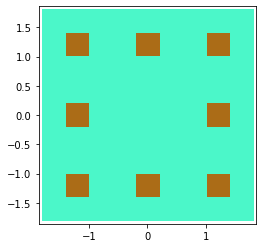

In [13]:
root.plot(width=(3.1*pitch, 3.1*pitch), color_by='material')

In [14]:
lat

RectLattice
	ID             =	3
	Name           =	
	Shape          =	(3, 3)
	Lower Left     =	[-1.7999999999999998, -1.7999999999999998]
	Pitch          =	[1.2, 1.2]
	Outer          =	None
	Universes      
1 1 1 
1 2 1 
1 1 1 

In [15]:
groups = openmc.mgxs.EnergyGroups((0.0, 20.0e6))

# Instantiate an MGXS library.
mgxs_lib = openmc.mgxs.Library(geometry)
mgxs_lib.energy_groups = groups

# Don't apply any anisotropic scattering corrections.
mgxs_lib.correction = None

# Set the desired MGXS data.
# TODO: what data is needed?
mgxs_lib.mgxs_types = ('total', 'absorption', 'nu-fission', 'scatter matrix', 'chi')

# Define the domain and build the library.
mgxs_lib.domain_type = 'cell'
mgxs_lib.domains = geometry.get_all_material_cells().values()
mgxs_lib.build_library()

# Add the tallies.
tallies = openmc.Tallies()
mgxs_lib.add_to_tallies_file(tallies)

tallies.export_to_xml()

/Users/sebastiantchakerian/Codes/openmc/openmc/mixin.py:67: IDWarning: Another Filter instance already exists with id=48.
  warn(msg, IDWarning)
/Users/sebastiantchakerian/Codes/openmc/openmc/mixin.py:67: IDWarning: Another Filter instance already exists with id=2.
  warn(msg, IDWarning)
/Users/sebastiantchakerian/Codes/openmc/openmc/mixin.py:67: IDWarning: Another Filter instance already exists with id=9.
  warn(msg, IDWarning)


In [16]:
settings = openmc.Settings()

settings.batches = 20
settings.inactive = 10
settings.particles = 1000

# only_fissionable performs a rejection sampling and only accepts source neutrons in material with fission xs
space = openmc.stats.Box((-1.5*pitch, -1.5*pitch, 0),
     (1.5*pitch, 1.5*pitch, 0), only_fissionable=True)
settings.source = openmc.Source(space=space)

settings.export_to_xml()

In [17]:
openmc.run()

                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

In [18]:
# Load the statepoint and the MGXS results.
sp = openmc.StatePoint('statepoint.20.h5')
mgxs_lib.load_from_statepoint(sp)

In [19]:
# Pick out the fuel and moderator domains.
fuel = mgxs_lib.domains[0]
moderator = mgxs_lib.domains[1]
center = mgxs_lib.domains[2]
assert fuel.name == 'fuel'
assert moderator.name == 'moderator'
assert center.name == 'guide'

In [20]:
#Obtain data in array form for necessary components using dataframes

df = mgxs_lib.get_mgxs(fuel, 'total').get_pandas_dataframe()
FuelXS_Total = df["mean"]
Fuel_D = (1/(3*FuelXS_Total)) #Fuel Diffusion Coefs
print(FuelXS_Total)

df = mgxs_lib.get_mgxs(moderator, 'total').get_pandas_dataframe()
ModeratorXS_Total = df["mean"]
Moderator_D = (1/(3*ModeratorXS_Total)) #Moderator Diffusion Coefs
print(ModeratorXS_Total)

df = mgxs_lib.get_mgxs(center, 'total').get_pandas_dataframe()
CenterXS_Total = df["mean"]
Center_D = (1/(3*CenterXS_Total)) #Center rod Diffusion Coefs

df = mgxs_lib.get_mgxs(fuel, 'absorption').get_pandas_dataframe()
FuelXS_Absorption = df["mean"]

df = mgxs_lib.get_mgxs(moderator, 'absorption').get_pandas_dataframe()
ModeratorXS_Absorption = df["mean"]

df = mgxs_lib.get_mgxs(center, 'absorption').get_pandas_dataframe()
CenterXS_Absorption = df["mean"]

df = mgxs_lib.get_mgxs(fuel, 'nu-fission').get_pandas_dataframe()
FuelXS_NuF = df["mean"]
print(FuelXS_NuF)


df = mgxs_lib.get_mgxs(fuel, 'chi').get_pandas_dataframe()
Fuel_Chi = df["mean"]


df = mgxs_lib.get_mgxs(fuel, 'scatter matrix').get_pandas_dataframe()
print(df)
#FuelXS_Scatter = df["mean"]

df = mgxs_lib.get_mgxs(moderator, 'scatter matrix').get_pandas_dataframe()
ModeratorXS_Scatter = df["mean"]
print(df)
df = mgxs_lib.get_mgxs(center, 'scatter matrix').get_pandas_dataframe()
CenterXS_Scatter = df["mean"]
print(df)


0    0.557271
Name: mean, dtype: float64
0    1.723028
Name: mean, dtype: float64
0    0.283212
Name: mean, dtype: float64
   cell  group in  group out nuclide      mean  std. dev.
0     1         1          1   total  0.389784   0.003989
   cell  group in  group out nuclide      mean  std. dev.
0     2         1          1   total  1.700361   0.014052
   cell  group in  group out nuclide      mean  std. dev.
0     3         1          1   total  1.799539   0.040441


In [21]:
'''
Variables are called:

FuelXS_Total
Fuel_D
FuelXS_Absorption
FuelXS_NuF
Fuel_Chi
ModeratorXS_Total
ModeratorXS_Absorption
Moderator_D
CenterXS_Total
CenterXS_Absorption
Center_D

'''

#Create function to autogenerate approporiate d-tilde

def dtilde(d1,d2,spacing):
    dtilde = 2 * d1 * d2/(spacing*(d1+d2))
    return dtilde

#---Generate problem mesh---

xWidth = 3.6
yWidth = 3.6
spacing = 0.4 #Must be equal to 0.4 or less by even amounts (0.2,0.1 etc)
x_rows = int(xWidth/spacing)
y_columns = int(yWidth/spacing)
num_cells = x_rows * y_columns
n_groups = 1 #1Group model

#Create a class for the cells

class cells:
    def __init__(self, material):
        self.material = material
    def matID(self):
        return self.material
    
#Use cell class to fill in an array of cell information. This will create a list of strings which correspond to the material of each cell
    
Cell_Info = []

#Cursor for moving through the geometry

xpos = spacing/2
ypos = spacing/2

for i in range(num_cells):
    if 2.0>xpos>1.6 and 2.0>ypos>1.6:
        Cell_Info.append(cells('Center'))
    elif (0.8>xpos>0.4 or 2.0>xpos>1.6 or 3.2>xpos>2.8) and (0.8>ypos>0.4 or 2.0>ypos>1.6 or 3.2>ypos>2.8):
        Cell_Info.append(cells('Fuel'))
    else:
        Cell_Info.append(cells('Moderator'))
    
    xpos = xpos + spacing #Move along x
    
    if xpos > 3.6: #If the x cursor needs to be reset, reset it
        xpos = spacing/2
        ypos = ypos + spacing #Move the y cursor for the next row of cells

#Instantiate Matricies

D_Matrix = np.zeros([n_groups*num_cells, n_groups*num_cells])
F_Matrix = np.zeros([n_groups*num_cells, n_groups*num_cells])


#---Fill in the matricies---

#Generate midpoint cursor used to track geometric position while filling in matrix

xpos = spacing/2
ypos = spacing/2

for i in range(num_cells):
    if xpos<spacing and ypos<spacing: #Corner cell 1
        DT_T = dtilde(Moderator_D, Moderator_D, spacing)
        DT_R = dtilde(Moderator_D, Moderator_D, spacing)
        DT_L = 0
        DT_B = 0
        D_Matrix[i,i] = ModeratorXS_Absorption * (spacing**2) + DT_T + DT_B + DT_R + DT_L
        D_Matrix[i,i+1] = -DT_R
        D_Matrix[i,i+y_columns] = -DT_T
        F_Matrix[i,i] = 0
    elif xpos>(xWidth-spacing) and ypos<spacing: #Corner cell 2
        DT_T = dtilde(Moderator_D, Moderator_D, spacing)
        DT_R = 0
        DT_L = dtilde(Moderator_D, Moderator_D, spacing)
        DT_B = 0
        D_Matrix[i,i] = ModeratorXS_Absorption * (spacing**2) + DT_T + DT_B + DT_R + DT_L
        D_Matrix[i,i-1] = -DT_L
        D_Matrix[i,i+y_columns] = -DT_T
        F_Matrix[i,i] = 0
    elif xpos<spacing and ypos>(yWidth-spacing): #Corner cell 3
        DT_T = 0
        DT_R = dtilde(Moderator_D, Moderator_D, spacing)
        DT_L = 0
        DT_B = dtilde(Moderator_D, Moderator_D, spacing)
        D_Matrix[i,i] = ModeratorXS_Absorption * (spacing**2) + DT_T + DT_B + DT_R + DT_L
        D_Matrix[i,i+1] = -DT_R
        D_Matrix[i,i-y_columns] = -DT_B
        F_Matrix[i,i] = 0
    elif xpos>(xWidth-spacing) and ypos>(yWidth-spacing): #Corner cell 4
        DT_T = 0
        DT_R = 0
        DT_L = dtilde(Moderator_D, Moderator_D, spacing)
        DT_B = dtilde(Moderator_D, Moderator_D, spacing)
        D_Matrix[i,i] = ModeratorXS_Absorption * (spacing**2) + DT_T + DT_B + DT_R + DT_L
        D_Matrix[i,i-1] = -DT_L
        D_Matrix[i,i-y_columns] = -DT_B
        F_Matrix[i,i] = 0
    elif xpos>(spacing) and ypos<spacing: #Bottom Edges
        #Perform check on above cell to see if it is fuel
        Material = Cell_Info[i+y_columns].matID()
        if Material == 'Fuel':
            DT_T = dtilde(Moderator_D, Fuel_D, spacing)
        else:
            DT_T = dtilde(Moderator_D, Moderator_D,spacing)
        DT_R = dtilde(Moderator_D, Moderator_D, spacing)
        DT_L = dtilde(Moderator_D, Moderator_D, spacing)
        DT_B = 0
        D_Matrix[i,i] = ModeratorXS_Absorption * (spacing**2) + DT_T + DT_B + DT_R + DT_L
        D_Matrix[i,i+1] = -DT_R
        D_Matrix[i,i-1] = -DT_L
        D_Matrix[i,i+y_columns] = -DT_T
        F_Matrix[i,i] = 0
    elif xpos<(spacing) and ypos>spacing: #Left Edges
        #Perform check on right cell to see if it is fuel
        Material = Cell_Info[i+1].matID()
        if Material == 'Fuel':
            DT_R = dtilde(Moderator_D, Fuel_D, spacing)
        else:
            DT_R = dtilde(Moderator_D, Moderator_D,spacing)
        DT_T = dtilde(Moderator_D, Moderator_D, spacing)
        DT_L = 0
        DT_B = dtilde(Moderator_D,Moderator_D,spacing)
        D_Matrix[i,i] = ModeratorXS_Absorption * (spacing**2) + DT_T + DT_B + DT_R + DT_L
        D_Matrix[i,i+1] = -DT_R
        D_Matrix[i,i-y_columns] = -DT_B
        D_Matrix[i,i+y_columns] = -DT_T
        F_Matrix[i,i] = 0
    elif xpos>(xWidth-spacing) and ypos>spacing: #Right Edges
        #Perform check on left cell to see if it is fuel
        Material = Cell_Info[i-1].matID()
        if Material == 'Fuel':
            DT_L = dtilde(Moderator_D, Fuel_D, spacing)
        else:
            DT_L = dtilde(Moderator_D, Moderator_D,spacing)
        DT_T = dtilde(Moderator_D, Moderator_D, spacing)
        DT_R = 0
        DT_B = dtilde(Moderator_D,Moderator_D,spacing)
        D_Matrix[i,i] = ModeratorXS_Absorption * (spacing**2) + DT_T + DT_B + DT_R + DT_L
        D_Matrix[i,i-1] = -DT_L
        D_Matrix[i,i-y_columns] = -DT_B
        D_Matrix[i,i+y_columns] = -DT_T
        F_Matrix[i,i] = 0
    elif xpos>spacing and ypos>(yWidth-spacing): #Top Edges
        #Perform check on bottom cell to see if it is fuel
        Material = Cell_Info[i-y_columns].matID()
        if Material == 'Fuel':
            DT_B = dtilde(Moderator_D, Fuel_D, spacing)
        else:
            DT_B = dtilde(Moderator_D, Moderator_D,spacing)
        DT_T = 0
        DT_R = dtilde(Moderator_D, Moderator_D, spacing)
        DT_B = dtilde(Moderator_D,Moderator_D,spacing)
        DT_L = dtilde(Moderator_D,Moderator_D,spacing)
        D_Matrix[i,i] = ModeratorXS_Absorption * (spacing**2) + DT_T + DT_B + DT_R + DT_L
        D_Matrix[i,i-1] = -DT_L
        D_Matrix[i,i+1] = -DT_R
        D_Matrix[i,i-y_columns] = -DT_B
        F_Matrix[i,i] = 0
    else: #The cell is interior type
        Cell_Type = Cell_Info[i].matID()
        Cell_T = Cell_Info[i+y_columns].matID()
        Cell_B = Cell_Info[i-y_columns].matID()
        Cell_L = Cell_Info[i-1].matID()
        Cell_R = Cell_Info[i+1].matID()
        if(Cell_Type == 'Fuel'):
            if(Cell_T == 'Fuel'):
                DT_T = dtilde(Fuel_D, Fuel_D, spacing)
            elif(Cell_T == 'Moderator'):
                DT_T = dtilde(Fuel_D, Moderator_D, spacing)
            elif(Cell_T == 'Center'):
                DT_T = dtilde(Fuel_D, Center_D, spacing)
            if(Cell_B == 'Fuel'):
                DT_B = dtilde(Fuel_D, Fuel_D, spacing)
            elif(Cell_B == 'Moderator'):
                DT_B = dtilde(Fuel_D, Moderator_D, spacing)
            elif(Cell_B == 'Center'):
                DT_B = dtilde(Fuel_D, Center_D, spacing)
            if(Cell_L == 'Fuel'):
                DT_L = dtilde(Fuel_D, Fuel_D, spacing)
            elif(Cell_L == 'Moderator'):
                DT_L = dtilde(Fuel_D, Moderator_D, spacing)
            elif(Cell_L == 'Center'):
                DT_L = dtilde(Fuel_D, Center_D, spacing)
            if(Cell_R == 'Fuel'):
                DT_R = dtilde(Fuel_D, Fuel_D, spacing)
            elif(Cell_R == 'Moderator'):
                DT_R = dtilde(Fuel_D, Moderator_D, spacing)
            elif(Cell_R == 'Center'):
                DT_R = dtilde(Fuel_D, Center_D, spacing)
            D_Matrix[i,i] = FuelXS_Absorption * (spacing**2) + DT_T + DT_B + DT_R + DT_L
            D_Matrix[i,i-1] = -DT_L
            D_Matrix[i,i+1] = -DT_R
            D_Matrix[i,i-y_columns] = -DT_B
            D_Matrix[i,i+y_columns] = -DT_T
            F_Matrix[i,i] = Fuel_Chi * FuelXS_NuF * (spacing**2)
        if(Cell_Type == 'Moderator'):
            if(Cell_T == 'Fuel'):
                DT_T = dtilde(Moderator_D, Fuel_D, spacing)
            elif(Cell_T == 'Moderator'):
                DT_T = dtilde(Moderator_D, Moderator_D, spacing)
            elif(Cell_T == 'Center'):
                DT_T = dtilde(Moderator_D, Center_D, spacing)
            if(Cell_B == 'Fuel'):
                DT_B = dtilde(Moderator_D, Fuel_D, spacing)
            elif(Cell_B == 'Moderator'):
                DT_B = dtilde(Moderator_D, Moderator_D, spacing)
            elif(Cell_B == 'Center'):
                DT_B = dtilde(Moderator_D, Center_D, spacing)
            if(Cell_L == 'Fuel'):
                DT_L = dtilde(Moderator_D, Fuel_D, spacing)
            elif(Cell_L == 'Moderator'):
                DT_L = dtilde(Moderator_D, Moderator_D, spacing)
            elif(Cell_L == 'Center'):
                DT_L = dtilde(Moderator_D, Center_D, spacing)
            if(Cell_R == 'Fuel'):
                DT_R = dtilde(Moderator_D, Fuel_D, spacing)
            elif(Cell_R == 'Moderator'):
                DT_R = dtilde(Moderator_D, Moderator_D, spacing)
            elif(Cell_R == 'Center'):
                DT_R = dtilde(Moderator_D, Center_D, spacing)
            D_Matrix[i,i] = ModeratorXS_Absorption * (spacing**2) + DT_T + DT_B + DT_R + DT_L
            D_Matrix[i,i-1] = -DT_L
            D_Matrix[i,i+1] = -DT_R
            D_Matrix[i,i-y_columns] = -DT_B
            D_Matrix[i,i+y_columns] = -DT_T
            F_Matrix[i,i] = 0
        if(Cell_Type == 'Center'):
            if(Cell_T == 'Fuel'):
                DT_T = dtilde(Center_D, Fuel_D, spacing)
            elif(Cell_T == 'Moderator'):
                DT_T = dtilde(Center_D, Moderator_D, spacing)
            elif(Cell_T == 'Center'):
                DT_T = dtilde(Center_D, Center_D, spacing)
            if(Cell_B == 'Fuel'):
                DT_B = dtilde(Center_D, Fuel_D, spacing)
            elif(Cell_B == 'Moderator'):
                DT_B = dtilde(Center_D, Moderator_D, spacing)
            elif(Cell_B == 'Center'):
                DT_B = dtilde(Center_D, Center_D, spacing)
            if(Cell_L == 'Fuel'):
                DT_L = dtilde(Center_D, Fuel_D, spacing)
            elif(Cell_L == 'Moderator'):
                DT_L = dtilde(Center_D, Moderator_D, spacing)
            elif(Cell_L == 'Center'):
                DT_L = dtilde(Center_D, Center_D, spacing)
            if(Cell_R == 'Fuel'):
                DT_R = dtilde(Center_D, Fuel_D, spacing)
            elif(Cell_R == 'Moderator'):
                DT_R = dtilde(Center_D, Moderator_D, spacing)
            elif(Cell_R == 'Center'):
                DT_R = dtilde(Center_D, Center_D, spacing)
            D_Matrix[i,i] = CenterXS_Absorption * (spacing**2) + DT_T + DT_B + DT_R + DT_L
            D_Matrix[i,i-1] = -DT_L
            D_Matrix[i,i+1] = -DT_R
            D_Matrix[i,i-y_columns] = -DT_B
            D_Matrix[i,i+y_columns] = -DT_T
            F_Matrix[i,i] = 0
        
    #Update position of the x cursor
    
    xpos = xpos + spacing
    
    #Update position for new row if needed
    
    if (xpos > 3.6): 
        xpos = spacing/2 #reset position of x cursor
        ypos = ypos + spacing #Move y cursor up one position
        
#DebugFrame = pd.DataFrame(D_Matrix)
#DebugFrame.to_csv('Matrix_Info.csv')

pd.DataFrame(F_Matrix).to_csv('1FissionMatrix.csv')

In [22]:
#---Generate Power Iteration Scheme---

def K_Converged(kguess,keff):
    tol = np.sqrt((1/num_cells) * ((keff-kguess)/keff)**2)
    return tol

def Phi_Converged(phiguess, phi):
    tol = np.sqrt((1/num_cells) * ((phi-phiguess)/phi)**2)
    return tol

tolerance = 1e-5

def Power_Iteration(phiguess, phinorm, kguess, D, F, num_cells):
    Phi_guess = phiguess / (sum(phiguess))
    RHS = (1/kguess) * np.dot(F, Phi_guess)
    kold = kguess
    phiold = Phi_guess
    phiold_sum = sum(phiold)
    D_inv = np.linalg.inv(D)
    Converged = False
    while Converged == False:
        Phi = np.dot(D_inv, RHS)
        Phi_sum = sum(Phi)
        keff = np.sum(np.dot(F,Phi)) / np.sum(np.dot(F,phiold)) * kold
        if K_Converged(kold,keff) <= tolerance and Phi_Converged(phiold_sum, Phi_sum) <= tolerance:
            Flux = Phi / (sum(Phi)) * phinorm
            K = keff
            RHS = RHS/(sum(RHS))
            Converged = True
            return Flux, K
        kold = keff
        phiold = Phi / sum(Phi) * phinorm
        phiold_sum = Phi_sum
        RHS = (1/kold)*np.dot(F,phiold)

In [ ]:
#---Utilize Power Iteration to Solve the 2D Diffusion Problem---

Phi_guess = np.ones([n_groups*num_cells]) #Generate a guess of the flux vector instantiated to 1s
Phinorm = sum(Phi_guess) #Initial normalized value
K_Guess = 1.0 #Guess K-effective

Phi,Keff = Power_Iteration(Phi_guess, Phinorm, K_Guess, D_Matrix, F_Matrix, num_cells)

In [ ]:
print(Keff) #The value we want to find

In [ ]:
#---Plot Mesh Refinement and K---

K = [0.98812, 1.00045, 0.9998, 0.99954, 0.99941] #Values can be reproduced by running the code with the corresponding spacing value
Mesh_R = [0.4,0.2,0.1,0.05,0.025] #refers to the dx=dy spacing in the mesh used

plt.figure(0)
plt.plot(Mesh_R,K)
plt.title('Keff as a function of the mesh refinement')
plt.xlabel('Dx=Dy spacing')
plt.ylabel('K-eff')

In [ ]:
#Larger spacing = worse results
#Ultimatley the spacing converges to around 1.000 no matter the mesh refinment
#This is okay.. but the MC result suggests our answer should be closer to 1.01